##### Import libraries

In [1]:
%load_ext rpy2.ipython 
# Load the R magic extension

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import patsy
from lifelines import CoxPHFitter 
import statsmodels as sm
from pathlib import Path

In [3]:
# Add the directory to sys.path
import sys
module_path = Path('./../code')
sys.path.append(str(module_path))
import utils

In [4]:
# Import libraries to allow data to be passed between Python and R env
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [5]:
%%R
# Run this cell to install packages the first time. 

# install.packages("bshazard")
# install.packages("survival")
# install.packages("tidyr")
# install.packages("dplyr")
# install.packages("magrittr")
# install.packages("tableone")
# install.packages("pROC")
# install.packages("PRROC")
# install.packages("caret")
# install.packages("survivalROC")
# install.packages("survminer")
# install.packages("scales")
# install.packages("broom")
# install.packages("purrr")


NULL


In [6]:
%%R
library(bshazard)
library(survival)
library(tidyr)
library(dplyr)
library(magrittr)
library(tableone)
library(pROC)
library(PRROC)
library(caret)
library(survivalROC)
library(survminer)
library(scales)
library(finalfit)
library(broom)
library(purrr)

R[write to console]: Loading required package: splines

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: Epi

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘magrittr’


R[write to console]: The following object is masked from ‘package:tidyr’:

    extract


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Loading required package: rlang

R[write to console]: 
Attaching package: ‘rlang’


R[write to console]: The following object is masked from ‘package:magrittr’:

    set_names


R[write to consol

In [7]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# Displays all the columns, does 
pd.set_option('display.max_columns', None)

In [8]:
demographics_table_filename = './../results/demographics_table.csv'
univariate_filename = './../results/univariate_analysis.csv'
multivariate_filename = './../results/multivariate_analysis.csv'

In [9]:
data_filename = './../data/cleaned_cohort_20250422.csv'
df = pd.read_csv(data_filename)[utils.VARS_TO_ANALYZE]
df.shape

(1745299, 75)

In [10]:
df.ugica.value_counts()

ugica
0.0    1744986
1.0        313
Name: count, dtype: int64

In [60]:
# Pass the DataFrame into the R environment
def pass_df(df):
    ro.globalenv['r_df'] = df

ro.globalenv['numerical_vars'] = utils.NUMERICAL_VARS
ro.globalenv['categorical_vars'] = utils.CATEGORICAL_VARS
ro.globalenv['demographics_table_filename'] = str(demographics_table_filename)
ro.globalenv['univariate_filename'] = str(univariate_filename)
ro.globalenv['multivariate_filename'] = str(multivariate_filename)

##### Add variables to compare with current guidelines for risk-factor triggered screening for EAC

In [12]:
def num_risk_factors(row):
    score = 0 

    if row.age > 50: 
        score += 1 
    if row.sex == 'MALE':
        score += 1 
    if row.race_clean == 'White':
        score += 1
    if row.tobacco_binary == '1':
        score += 1
    if row.gerd == '1':
        score += 1
    if row.BMI_baseline >= 30:
        score += 1 
    if row.famhx_esophagealca or row.famhx_barretts:
        score += 1 
    
    return score 

df['eac_risk_factors_screening'] = df.head().apply(lambda x: num_risk_factors(x), axis=1)
df['meets_screening'] = (df.eac_risk_factors_screening >= 3).astype(int)

In [13]:
pass_df(df)

/Users/alyssa.chen/miniconda3/envs/rpy2_env/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "subtype". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


##### Demographics table

In [14]:
%%R 
vars_to_analyze <- unlist(c(categorical_vars, numerical_vars))

demtable <- CreateTableOne(
    vars = vars_to_analyze,
    data = r_df,
    factorVars = unlist(categorical_vars),
    strata = "ugica",
    addOverall = TRUE,
    includeNA = TRUE
)
demtable_df <- print(demtable, quote = FALSE, noSpaces = TRUE, printToggle = FALSE, missing = TRUE)

write.csv(demtable_df, file = demographics_table_filename)

##### Preprocessing
Normalize continuous variables

In [16]:
%%R 
# Remove outcome variable from list to avoid normalizing
numerical_vars <- numerical_vars[numerical_vars != "months_to_event"]

preproc <- preProcess(r_df[, unlist(numerical_vars)], method = c("center", "scale"))
r_df_normal <- predict(preproc, r_df)


Factorize categorical variables

In [18]:
%%R
# Remove categorical variables that we do not want to do univariate analysis on
categorical_vars <- categorical_vars[!categorical_vars %in% c("ugica", "death", "subtype", "social_language")]

# Factorize 
for (i in categorical_vars) {
    r_df_normal[[i]] <- factor(r_df_normal[[i]])
}

# Set reference levels 
r_df_normal$race_clean <- relevel(r_df_normal$race_clean, ref = 'White')
r_df_normal$race_clean_missing <- relevel(r_df_normal$race_clean_missing, ref = 'White')
r_df_normal$ethnicity <- relevel(r_df_normal$ethnicity, ref='Not Hispanic or Latino')
r_df_normal$ethnicity_missing <- relevel(r_df_normal$ethnicity_missing, ref='Not Hispanic or Latino')
r_df_normal$alcohol_all <- relevel(r_df_normal$alcohol_all, ref = '0.0')
r_df_normal$alcohol_all_missing <- relevel(r_df_normal$alcohol_all_missing, ref = '0')
r_df_normal$alcohol_binary <- relevel(r_df_normal$alcohol_binary, ref = '0')
r_df_normal$alcohol_binary_missing <- relevel(r_df_normal$alcohol_binary_missing, ref = '0')
r_df_normal$tobacco_all <- relevel(r_df_normal$tobacco_all, ref = '0.0')
r_df_normal$tobacco_all_missing <- relevel(r_df_normal$tobacco_all_missing, ref = '0')
r_df_normal$tobacco_binary <- relevel(r_df_normal$tobacco_binary, ref = '0')
r_df_normal$tobacco_binary_missing <- relevel(r_df_normal$tobacco_binary_missing, ref = '0')
r_df_normal$hpylori_active <- relevel(r_df_normal$hpylori_active, ref = '0.0')
r_df_normal$hpylori_active_missing <- relevel(r_df_normal$hpylori_active_missing, ref = '0')
r_df_normal$hpylori_active_chronic <- relevel(r_df_normal$hpylori_active_chronic, ref = '0.0')
r_df_normal$hpylori_active_chronic_missing <- relevel(r_df_normal$hpylori_active_chronic_missing, ref = '0')
r_df_normal$hpylori_active_chronic_binary <- relevel(r_df_normal$hpylori_active_chronic_binary, ref = '0')

##### Univariate analysis

In [20]:
%%R
# HRs, 95% CIs, p-values
results_list <- list()

for (i in c(numerical_vars, categorical_vars)) {
    # Skip if fewer than 2 levels
    if (length(unique(na.omit(r_df_normal[[i]]))) < 2) next

    formula <- as.formula(paste("Surv(months_to_event, ugica) ~", i))
    model <- coxph(formula, data=r_df_normal)

    model_summary <- summary(model)
    coef <- exp(model_summary$coef[, "coef"])
    confint_vals <- exp(confint(model))
    p_value <- model_summary$coef[, "Pr(>|z|)"]

    # Extract full term names (e.g., "sexMale", "stageIII")
    terms <- rownames(model_summary$coef)

    # Extract factor levels (remove variable name prefix)
    is_factor <- i %in% categorical_vars
    levels_clean <- if (is_factor) {
        sub(paste0("^", i), "", terms)
    } else {
        terms  # use full term name for numeric variables
    }

    model_df <- data.frame(
        Variable = i,
        Level = levels_clean,
        HR = coef,
        CI_lower = confint_vals[, 1],
        CI_upper = confint_vals[, 2],
        p_value = p_value
    )

    results_list[[i]] <- model_df
}

final_results <- do.call(rbind, results_list)
write.csv(final_results, univariate_filename)

In [53]:
# Print the list of significant variables based on univariate analysis
df_univariate = pd.read_csv(univariate_filename)

##### Feature selection

In [52]:
%%R 
selected_vars <- final_results %>%
    filter(p_value < 0.05) %>%
    distinct(Variable) %>%
    pull(Variable)
selected_vars

selected_vars <- selected_vars[!selected_vars %in% c("days_to_death", "death", "subtype", "ugica", "diagnosis_year", "encounter_type", "visit_year", "hgball_baseline", "hgb_baseline",
    "bun_baseline", "LDL_baseline", "sodium_baseline", "scr_baseline", "hgba1c_baseline",
    "alcohol_all", "alcohol_all_missing", "alcohol_binary_missing",
    "sex_missing", "race_clean_missing")]
selected_vars

 [1] "hgball_baseline_imputed_mean" "sex"                         
 [3] "race_clean"                   "ethnicity"                   
 [5] "alcohol_binary"               "pud"                         
 [7] "gerd"                         "cad"                         
 [9] "barretts"                     "famhx_cancer"                
[11] "famhx_gastricca"              "famhx_colonca"               
[13] "ASA"                          "PPI"                         


##### CoxPH multivariate model training

In [219]:
%%R 
library(dplyr)
library(caret)
library(gridExtra)

# Partitions data into training and validation set, percentage split p 
partition_data <- function(data, selected_vars, seed = 123, p = 0.8) {
  rdf <- data %>%
    select(months_to_event, ugica, all_of(selected_vars)) %>%
    drop_na()
  
  set.seed(seed)
  train_index <- createDataPartition(rdf$ugica, p = p, list = FALSE)
  
  train_set <- rdf[train_index, ]
  validation_set <- rdf[-train_index, ]
  
  # Check the distribution of 'ugica' in each set
  print(paste(c("Dataset Controls", "Dataset Cases"), table(data$ugica)))  # Original dataset
  print(paste(c("Training Controls", "Training Cases"), table(train_set$ugica)))  # Training set
  print(paste(c("Validation Controls", "Validation Cases"), table(validation_set$ugica)))  # Validation set

  list(train_set = train_set, validation_set = validation_set)
}

# Trains model
train_model <- function(train_set, selected_vars, model_func = coxph) {
  formula_str <- paste("Surv(months_to_event, ugica) ~", paste(selected_vars, collapse = " + "))
  formula <- as.formula(formula_str)
  model <- model_func(formula, data = train_set)
  return(model)
}

# Gets risk estimate
calculate_risk <- function(cox_model, validation_set, horizon_months = 60) {
  baseline_hazard <- basehaz(cox_model, centered = FALSE)
  H0_t <- approx(baseline_hazard$time, baseline_hazard$hazard, xout = horizon_months)$y
  
  linear_predictor <- predict(cox_model, newdata = validation_set, type = "lp")
  H_t_X <- H0_t * exp(linear_predictor)
  risk <- 1 - exp(-H_t_X)
  
  event <- as.numeric(validation_set$months_to_event <= horizon_months & validation_set$ugica == 1)
  
  list(risk = risk, event = event)
}

# Get sensitivity and specificity 
calculate_cm_by_percentile <- function(risk, event, threshold) {
    # Convert the continuous risk scores to binary predictions
    predicted_class <- ifelse(risk >= threshold, 1, 0)

    cm <- table(event, predicted_class)

    # Extracting the values from the confusion matrix
    TN <- cm[1, 1]
    FP <- cm[1, 2]
    FN <- cm[2, 1]
    TP <- cm[2, 2]

    # Sensitivity (True Positive Rate)
    sensitivity <- TP / (TP + FN)

    # Specificity (True Negative Rate)
    specificity <- TN / (TN + FP)

    # Positive Predictive Value (PPV) (Precision)
    ppv <- TP / (TP + FP)

    # Negative Predictive Value (NPV)
    npv <- TN / (TN + FN) 

    # Number Needed to Screen (NNS)
    # cer <- (TP + FN) / (TN + FP + FN + TP) # control event rate is cases/entire population 
    cer <- FN / (FN + TN) # control event rate is the number of cases in those not screened 
    ser <- TP / (TP + FP) # screened event rate is the number of cases found / those screened 
    aer <- ser - cer # absolute event reduction 
    nns <- 1/aer 

    # Print the results
    cat("Sensitivity:", sensitivity, "\n")
    cat("Specificity:", specificity, "\n")
    cat("PPV:", ppv, "\n")
    cat("NPV:", npv, "\n")
    cat("NNS:", nns, "\n")

    print(cm)
}

# Plots ROC curve
plot_roc_gg <- function(event, risk) {
  roc_obj <- roc(event, risk)
  df <- data.frame(
    FPR = 1 - roc_obj$specificities,
    TPR = roc_obj$sensitivities
  )
  auroc <- round(auc(roc_obj), 2)

  ggplot(df, aes(x = FPR, y = TPR)) +
    geom_line(color = "blue", size = 1.2) +
    geom_abline(linetype = "dashed", color = "gray") +
    annotate("text", x = 0.6, y = 0.1, label = paste("AUROC =", auroc), size = 5) +
    labs(title = "ROC Curve", x = "False Positive Rate", y = "True Positive Rate") +
    theme_minimal()
}

# Plots precision-recall curve
plot_pr_gg <- function(event, risk) {
  pr <- pr.curve(scores.class0 = risk[event == 1], scores.class1 = risk[event == 0], curve = TRUE)
  df <- data.frame(Recall = pr$curve[, 1], Precision = pr$curve[, 2])
  aucpr <- round(pr$auc.integral, 2)

  ggplot(df, aes(x = Recall, y = Precision)) +
    geom_line(color = "darkgreen", size = 1.2) +
    annotate("text", x = 0.6, y = 0.4, label = paste("AUC-PR =", aucpr), size = 5, color = "red") +
    labs(title = "Precision-Recall Curve", x = "Recall", y = "Precision") +
    theme_minimal()
}

# Plots Kaplan-Meier survival curve
plot_km_gg <- function(df, ylim = c(0.915, 1.00)) {
  surv_obj <- Surv(time = df$time, event = df$event)
  fit <- survfit(surv_obj ~ group, data = df)

  g <- ggsurvplot(
    fit,
    data = df,
    risk.table = TRUE,
    pval = TRUE,
    conf.int = TRUE,
    xlab = "Months to Event",
    ylab = "Survival Probability",
    ylim = ylim,
    ggtheme = theme_minimal()
  )

  return(g$plot)
}


[1] "Dataset Controls 1744986" "Dataset Cases 313"       
[1] "Training Controls 27121" "Training Cases 250"     
[1] "Validation Controls 6780" "Validation Cases 62"     
Sensitivity: 0.7096774 
Specificity: 0.7013654 
PPV: 0.01070039 
NPV: 0.9981195 
NNS: 113.3799 
     predicted_class
event    0    1
    0 4777 2034
    1    9   22


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



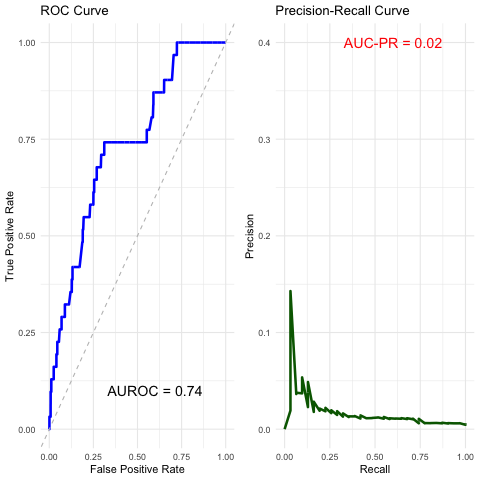

In [224]:
%%R 

# Partition data
splits <- partition_data(r_df_normal, selected_vars, p=0.8)
train_set <- splits$train_set
validation_set <- splits$validation_set

# Train model
cox_model <- train_model(train_set, selected_vars, model_func=coxph)

# Gets hazard ratio from multivariate analysis
model_summary <- summary(cox_model)
coef <- exp(model_summary$coef[, "coef"])
confint_vals <- exp(confint(cox_model))
p_value <- model_summary$coef[, "Pr(>|z|)"]
terms <- rownames(model_summary$coef)

model_df <- data.frame(
    Variable = terms,
    HR = coef,
    CI_lower = confint_vals[, 1],
    CI_upper = confint_vals[, 2],
    p_value = p_value
)

write.csv(model_df, multivariate_filename)

# Estimate risk
risk_result <- calculate_risk(cox_model, validation_set)
risk_5_years <- risk_result$risk
event_5_years <- risk_result$event

# Set risk threshold to calculate sensitivity and specificity
percentile = 70
threshold <- quantile(risk_5_years, probs = percentile / 100)
calculate_cm_by_percentile(risk_5_years, event_5_years, threshold)

# Generate all plots
p1 <- plot_roc_gg(event_5_years, risk_5_years)
p2 <- plot_pr_gg(event_5_years, risk_5_years)

# Show all plots in a grid (KM comes with table, so best shown separately)
grid.arrange(p1, p2, nrow=1)  # ROC and PR side-by-side


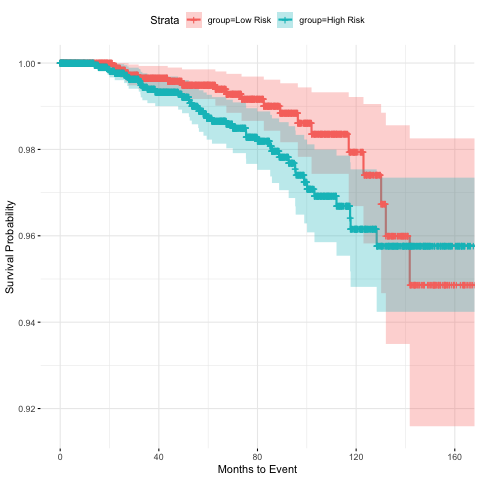

In [186]:
%%R 
# Plot Kaplan Meier curve 
df.km <- data.frame(
risk_5_years = risk_5_years,
time = validation_set$months_to_event,
event = validation_set$ugica
)

df.km$group <- ifelse(df.km$risk_5_years > median(df.km$risk_5_years), 1, 0)
df.km$group <- factor(df.km$group, levels = c(0, 1), labels = c("Low Risk", "High Risk"))

km <- plot_km_gg(df.km)
print(km)

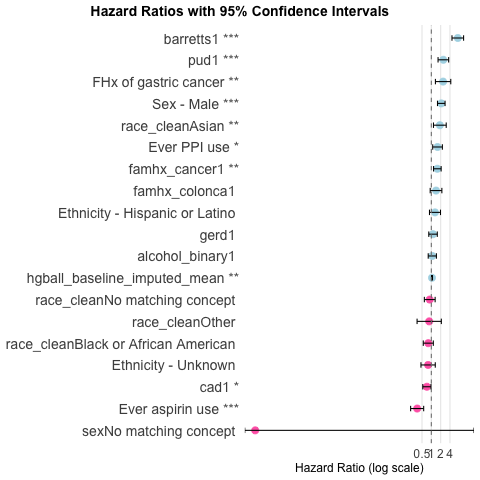

In [225]:
%%R 
pretty_names <- c(
"ethnicityNo matching concept" = "Ethnicity - Unknown",
"alcohol_binary_missing" = "Ever alcohol use", 
"ASA1" = "Ever aspirin use",
"race_clean_allNative Hawaiian or Other Pacific Islander" = "Race - Native Hawaiian or Other Pacific Islander",
"tobacco_binary1.0" = "Ever tobacco use",
"NSAID1" = "Ever NSAID use",
"hgb_imputed_scaled" = "Most recent hemoglobin",
"race_clean_allOther" = "Race - Other",
"race_clean_allNA" = "Race - Unknown",
"ethnicityHispanic or Latino" = "Ethnicity - Hispanic or Latino",
"race_clean_allBlack or African American" = "Race - Black or African American",
"age_scaled" = "Age",
"alcohol_binary_missing:tobacco_binary1.0" = "Alcohol + tobacco use interaction",
"race_clean_allAsian" = "Race - Asian",
"sexMALE" = "Sex - Male",
"famhx_gastricca1" = "FHx of gastric cancer",
"hpylori_binary1.0" = "Active or chronic H.pylori infection",
"PPI1" = "Ever PPI use"
)

# Define color and label formatting
model_df <- model_df %>%
  mutate(
    Variable_pretty = pretty_names[Variable],
    Variable_pretty = ifelse(is.na(Variable_pretty), Variable, Variable_pretty),
    sig = case_when(
      p_value < 0.001 ~ "***",
      p_value < 0.01 ~ "**",
      p_value < 0.05 ~ "*",
      TRUE ~ ""
    ),
    hr_label = sprintf("%.2f (%.2f–%.2f)", HR, CI_lower, CI_upper),
    Variable_labeled = paste0(Variable_pretty, " ", sig),  # add asterisks here
    color_group = ifelse(HR >= 1, "HR > 1", "HR < 1")
  ) %>%
  arrange(HR) %>%
  mutate(Variable_labeled = factor(Variable_labeled, levels = unique(Variable_labeled)))

# Plot
ggplot(model_df, aes(x = HR, y = Variable_labeled)) +
  geom_point(aes(color = color_group), size = 3) +
  geom_errorbarh(aes(xmin = CI_lower, xmax = CI_upper), height = 0.25) +
  geom_vline(xintercept = 1, linetype = "dashed", color = "gray50") +
  scale_color_manual(
    values = c("HR > 1" = "lightblue", "HR < 1" = "hotpink"),
    guide = "none"
  ) +
  scale_x_continuous(
    trans = "log10",
    breaks = c(0.5, 1, 2, 4),
    labels = c("0.5", "1", "2", "4")
  ) +
  labs(
    title = "Hazard Ratios with 95% Confidence Intervals",
    x = "Hazard Ratio (log scale)",
    y = NULL
  ) +
  theme_minimal(base_size = 12) +
  theme(
    axis.text.y = element_text(size = 14),
    axis.text.x = element_text(size = 12),
    plot.title.position = "plot",             # Title alignment
    plot.title = element_text(face = "bold", size = 14, hjust = 0.5),  # Centered title
    panel.grid.major.y = element_blank(),
    panel.grid.minor.x = element_blank()
  )
